In [1]:
import numpy as np

from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

In [2]:
#load dataframe from csv
demographics_data = pd.read_csv("data/newdata/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
demographics_data = demographics_data.drop(columns=["Geo_ZCTA5", "Geo_ZCTA3", "Geo_LOGRECNO", "Geo_GEOCOMP", "Geo_SUMLEV"])

(33120, 2151)


In [3]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [4]:
# drop any column with missing values greater than 5%
demographics_data.drop(columns=["SE_A18007_006","SE_A18007_007","SE_A18007_005","SE_A18007_004",
                     "SE_A18007_003","SE_A18007_002","SE_A18008_011",
                     "SE_A18008_010","SE_A18008_009","SE_A18010_002",
                     "SE_A18010_003","SE_A18010_004","SE_A18010_005",
                     "SE_A18010_006","SE_A18010_007","SE_A18008_001","SE_A18008_002",
                     "SE_A18008_003","SE_A18008_008","SE_A18008_007","SE_A18008_006","SE_A18008_005",
                     "SE_A18008_004"], axis=1, inplace=True)

In [47]:
reduced_demos = demographics_data[["SE_A00002_002", "SE_A14028_001", "SE_A14011_001", "SE_A14008_001", "SE_B10040_002", "SE_B10040_003"]]

In [48]:
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
reduced_demos = MinMaxScaler().fit_transform(reduced_demos)

SE_A14028_001     948
SE_A14011_001    1662
dtype: int64
(31458, 2)


What does MinMaxScaler Scaler do to our data?

In [49]:
print(reduced_demos[0:5])

   SE_A14028_001  SE_A14011_001
0         0.5238    20888.83581
1         0.5034    27986.62033
2         0.5666    31688.46383
3         0.4818    18625.70601
4         0.4689    30554.08275


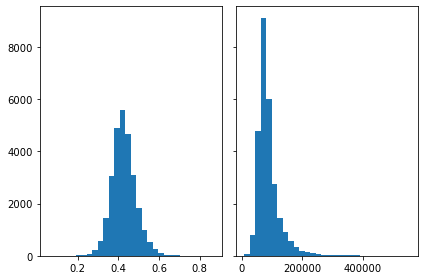

In [95]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

n_bins = 30

# We can set the number of bins with the `bins` kwarg
axs[0].hist(reduced_demos["SE_A14028_001"], bins=n_bins)
axs[1].hist(reduced_demos["SE_A14011_001"], bins=n_bins)
plt.show()

Let's see if we can just hack finding the best params for DBSCAN

 For epsilon   0.01  and samples  5  we get clusters:  0  and noise points:  31458
 For epsilon   0.1  and samples  5  we get clusters:  112  and noise points:  20884
 For epsilon   0.5  and samples  5  we get clusters:  26  and noise points:  2335
 For epsilon   1.0  and samples  5  we get clusters:  3  and noise points:  440
 For epsilon   2.0  and samples  5  we get clusters:  2  and noise points:  67
 For epsilon   10.0  and samples  5  we get clusters:  1  and noise points:  0
 For epsilon   0.01  and samples  10  we get clusters:  0  and noise points:  31458
 For epsilon   0.1  and samples  10  we get clusters:  28  and noise points:  24111
 For epsilon   0.5  and samples  10  we get clusters:  5  and noise points:  3140
 For epsilon   1.0  and samples  10  we get clusters:  2  and noise points:  591
 For epsilon   2.0  and samples  10  we get clusters:  3  and noise points:  138
 For epsilon   10.0  and samples  10  we get clusters:  1  and noise points:  0
 For epsilon   0.01  

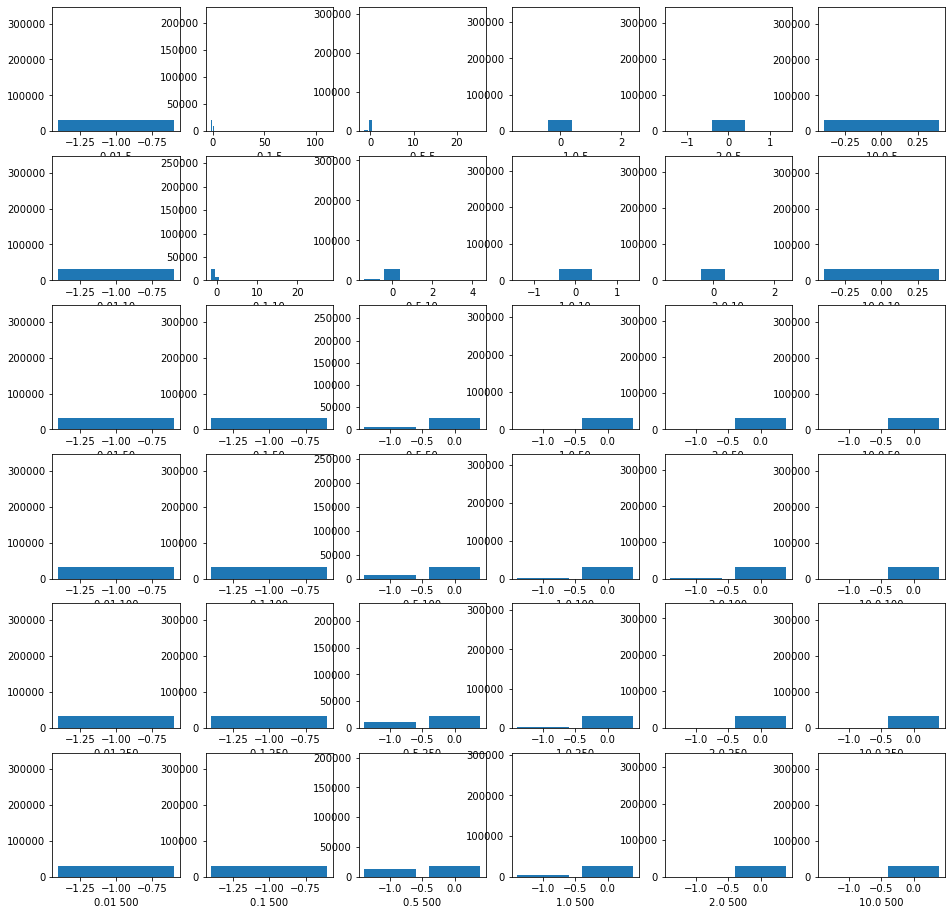

In [56]:

eps = [0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
samples = [5, 10, 50, 100, 250, 500]

fig, axes = plt.subplots(6, 6, figsize = (16, 16))

for i, ax in enumerate(axes.reshape(-1)):
    s = samples[int(i/6)]
    e = eps[int(i % 6)]
    # define the model
    dbscan_model = DBSCAN(eps=e, min_samples=s)

    # train the model
    dbscan_model.fit(reduced_demos)

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(" For epsilon  ", e, " and samples ", s, " we get clusters: ", n_clusters_, " and noise points: ", n_noise_)

    clusters = np.unique(labels, return_counts=True)
    ax.bar(clusters[0],clusters[1])
    ax.set_xlabel(str(e) + " " + str(s))
    ax.set_ymargin(10)

# plt.tightlayout()
plt.show()

How does our best DBSCAN approach look?

In [13]:
dbscan_model_refined = DBSCAN(eps=0.5, min_samples=5)

# train the model
dbscan_model_refined.fit(reduced_demos)

core_samples_mask = np.zeros_like(dbscan_model_refined.labels_, dtype=bool)
core_samples_mask[dbscan_model_refined.core_sample_indices_] = True
labels = dbscan_model_refined.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print(" FOR EPS : ", e, " AND SAMPLES ", s)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = reduced_demos[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

 FOR EPS :  1.0  AND SAMPLES  5
Estimated number of clusters: 26
Estimated number of noise points: 2335
number of members in cluster  0 :  28271
number of members in cluster  1 :  5
number of members in cluster  2 :  4
number of members in cluster  3 :  2
number of members in cluster  4 :  2
number of members in cluster  5 :  2
number of members in cluster  6 :  1
number of members in cluster  7 :  3
number of members in cluster  8 :  1
number of members in cluster  9 :  5
number of members in cluster  10 :  2
number of members in cluster  11 :  2
number of members in cluster  12 :  8
number of members in cluster  13 :  2
number of members in cluster  14 :  2
number of members in cluster  15 :  1
number of members in cluster  16 :  1
number of members in cluster  17 :  1
number of members in cluster  18 :  1
number of members in cluster  19 :  1
number of members in cluster  20 :  1
number of members in cluster  21 :  1
number of members in cluster  22 :  3
number of members in cluster

In [22]:
demographics_data = demographics_data.fillna(demographics_data.mean())
#reduced_all = StandardScaler().fit_transform(demographics_data)

# make sure we don't have the zip codes in our data
# but do make sure we can use them later, so split the data set
demographics_data_zip_codes = demographics_data["zip"]
demographics_data_no_zip = demographics_data.drop("zip", axis=1)

# scale all our values except Zip Code down:
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(demographics_data_no_zip)
print(scaled_all.shape)
print(scaled_all[0:5])


(33120, 2122)
[[0.14039116 0.14039116 0.00097285 ... 0.04167478 0.01794072 0.00612089]
 [0.31300992 0.31300992 0.00455805 ... 0.11450828 0.06357254 0.00841622]
 [0.39746283 0.39746283 0.00560552 ... 0.21129503 0.04602184 0.013772  ]
 [0.05241259 0.05241259 0.00055238 ... 0.02336904 0.0074103  0.00420811]
 [0.22043904 0.22043904 0.00273702 ... 0.0946446  0.02145086 0.00612089]]


Trying DBSCAN on all the data to see if it gives better results

Running a DBSCAN on all the data takes about 3 hours :/

In [38]:

dbscan_model_all = DBSCAN(eps=10.0, min_samples=2)

# train the model
dbscan_model_all.fit(scaled_all)

# now check our clusters
core_samples_mask = np.zeros_like(dbscan_model_all.labels_, dtype=bool)
core_samples_mask[dbscan_model_all.core_sample_indices_] = True
labels = dbscan_model_all.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# print(" FOR EPS : ", e, " AND SAMPLES ", s)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = scaled_all[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

Estimated number of clusters: 37
Estimated number of noise points: 14367
number of members in cluster  0 :  18674
number of members in cluster  1 :  2
number of members in cluster  2 :  2
number of members in cluster  3 :  2
number of members in cluster  4 :  3
number of members in cluster  5 :  2
number of members in cluster  6 :  2
number of members in cluster  7 :  3
number of members in cluster  8 :  2
number of members in cluster  9 :  2
number of members in cluster  10 :  2
number of members in cluster  11 :  2
number of members in cluster  12 :  2
number of members in cluster  13 :  2
number of members in cluster  14 :  2
number of members in cluster  15 :  2
number of members in cluster  16 :  2
number of members in cluster  17 :  3
number of members in cluster  18 :  2
number of members in cluster  19 :  4
number of members in cluster  20 :  2
number of members in cluster  21 :  2
number of members in cluster  22 :  2
number of members in cluster  23 :  2
number of members in 

Maybe we can reduce the dimenssions with PCA first and then run it?

In [24]:
from sklearn.decomposition import PCA

#run PCA with 20 components, the first captures 77% of the variance, which seems weird
pca = PCA(n_components=20)

scaled_all_pca = pca.fit_transform(scaled_all)

print(pca.explained_variance_ratio_)
print(" percent of variance captured:: ", np.sum(pca.explained_variance_ratio_))

[0.77448479 0.0501509  0.02451345 0.01979966 0.01013345 0.00852363
 0.00579488 0.00533748 0.00478141 0.00378477 0.00352103 0.00322128
 0.00278521 0.00270193 0.00234898 0.00212586 0.00200442 0.00193203
 0.00179749 0.00154444]
 percent of variance captured::  0.9312871191639139


 For epsilon   0.1  and samples  3  we get clusters:  232  and noise points:  29294
 For epsilon   0.2  and samples  3  we get clusters:  87  and noise points:  15657
 For epsilon   0.5  and samples  3  we get clusters:  88  and noise points:  6954
 For epsilon   0.75  and samples  3  we get clusters:  73  and noise points:  3917
 For epsilon   1.0  and samples  3  we get clusters:  50  and noise points:  2109
 For epsilon   2.0  and samples  3  we get clusters:  15  and noise points:  260
 For epsilon   0.1  and samples  5  we get clusters:  53  and noise points:  30385
 For epsilon   0.2  and samples  5  we get clusters:  23  and noise points:  16485
 For epsilon   0.5  and samples  5  we get clusters:  20  and noise points:  7454
 For epsilon   0.75  and samples  5  we get clusters:  24  and noise points:  4381
 For epsilon   1.0  and samples  5  we get clusters:  12  and noise points:  2495
 For epsilon   2.0  and samples  5  we get clusters:  7  and noise points:  335
 For epsilon

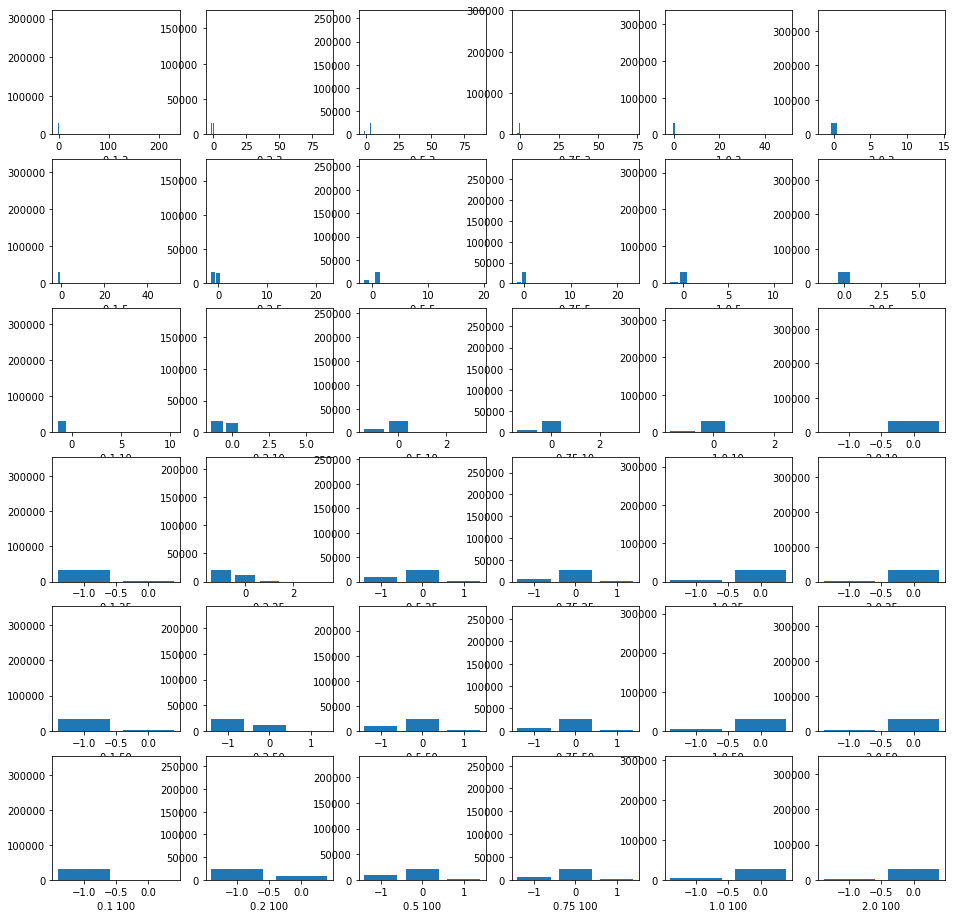

In [20]:

eps = [0.1, 0.2, 0.5, 0.75, 1.0, 2.0, 4.0]
samples = [3, 5, 10, 25, 50, 100]

fig, axes = plt.subplots(6, 6, figsize = (16, 16))

for i, ax in enumerate(axes.reshape(-1)):
    s = samples[int(i/6)]
    e = eps[int(i % 6)]
    # define the model
    dbscan_model = DBSCAN(eps=e, min_samples=s)

    # train the model
    dbscan_model.fit(reduced_all_pca)

    core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
    core_samples_mask[dbscan_model.core_sample_indices_] = True
    labels = dbscan_model.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(" For epsilon  ", e, " and samples ", s, " we get clusters: ", n_clusters_, " and noise points: ", n_noise_)

    clusters = np.unique(labels, return_counts=True)
    ax.bar(clusters[0],clusters[1])
    ax.set_xlabel(str(e) + " " + str(s))
    ax.set_ymargin(10)

plt.show()

In [25]:
dbscan_model_new = DBSCAN(eps=0.75, min_samples=5)

# train the model
dbscan_model_new.fit(scaled_all_pca)

core_samples_mask = np.zeros_like(dbscan_model_new.labels_, dtype=bool)
core_samples_mask[dbscan_model_new.core_sample_indices_] = True
labels = dbscan_model_new.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

unique_labels = set(labels)
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = scaled_all_pca[class_member_mask & core_samples_mask]
    print("number of members in cluster ", k, ": ", len(xy))

Estimated number of clusters: 24
Estimated number of noise points: 4381
number of members in cluster  0 :  26441
number of members in cluster  1 :  1
number of members in cluster  2 :  1
number of members in cluster  3 :  1
number of members in cluster  4 :  1499
number of members in cluster  5 :  1
number of members in cluster  6 :  1
number of members in cluster  7 :  3
number of members in cluster  8 :  2
number of members in cluster  9 :  2
number of members in cluster  10 :  3
number of members in cluster  11 :  1
number of members in cluster  12 :  1
number of members in cluster  13 :  1
number of members in cluster  14 :  1
number of members in cluster  15 :  1
number of members in cluster  16 :  1
number of members in cluster  17 :  1
number of members in cluster  18 :  1
number of members in cluster  19 :  1
number of members in cluster  20 :  1
number of members in cluster  21 :  1
number of members in cluster  22 :  1
number of members in cluster  23 :  2
number of members i

Peter suggested trying HDBScan, which is a variation on DBSCAN https://hdbscan.readthedocs.io/ 
    
We use it in the same way as DBSCAN so first we can try it on our non-PCA'd data:

In [ ]:
import hdbscan

cluster_sizes = [3, 5, 10, 25, 50]

for cs in cluster_sizes:
    
    print("with cluster_size ", cs)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=cs, min_samples=3)
    clusterer.fit(scaled_all)
    
    labels = clusterer.labels_

    unique_labels = set(labels)
    for k in unique_labels:
        class_member_mask = (labels == k)
        xy = scaled_all[class_member_mask]
        print("number of members in cluster ", k, ": ", len(xy))
    
    print(" ---------------------------------------------------- ")

with cluster_size  3


Now let's see how it does on the data that's been reduced using PCA

In [35]:
import hdbscan

cluster_sizes = [10, 25, 50, 100, 250, 1000]
min_samples = [3, 10, 20, 50, 100, 250]

for c in cluster_sizes:
    for m in min_samples:
        print("with cluster_size ", c, " and min samples ", m)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=c, min_samples=m)
        clusterer.fit(scaled_all_pca)

        labels = clusterer.labels_
        unique_labels = set(labels)
        print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum())
#         for k in unique_labels:
#             class_member_mask = (labels == k)
#             xy = scaled_all_pca[class_member_mask]
#             print("number of members in cluster ", k, ": ", len(xy))

        print(" ---------------------------------------------------- ")

with cluster_size  10  and min samples  3
 clusters:  80  and noise points  29898
 ---------------------------------------------------- 
with cluster_size  10  and min samples  10
 clusters:  22  and noise points  30977
 ---------------------------------------------------- 
with cluster_size  10  and min samples  20
 clusters:  12  and noise points  30958
 ---------------------------------------------------- 
with cluster_size  10  and min samples  50
 clusters:  8  and noise points  31159
 ---------------------------------------------------- 
with cluster_size  10  and min samples  100
 clusters:  4  and noise points  31329
 ---------------------------------------------------- 
with cluster_size  10  and min samples  250
 clusters:  3  and noise points  8459
 ---------------------------------------------------- 
with cluster_size  25  and min samples  3
 clusters:  18  and noise points  30590
 ---------------------------------------------------- 
with cluster_size  25  and min samples

Does our reduced data set do any better in HDBSCAN?

In [66]:
import hdbscan

cluster_sizes = [3, 5, 10, 25, 100, 1000]
min_samples = [3, 5, 10]

for c in cluster_sizes:
    for m in min_samples:
        print("with cluster_size ", c, " and min samples ", m)

        clusterer = hdbscan.HDBSCAN(min_cluster_size=c, min_samples=m, cluster_selection_method='leaf')
        clusterer.fit(reduced_demos)

        labels = clusterer.labels_
        unique_labels = set(labels)
        print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum(), ", noise as : ", (labels == -1).sum()/len(labels))
#         for k in unique_labels:
#             class_member_mask = (labels == k)
#             print("number of members in cluster ", k , " ", (labels == k).sum())
        print(" ---------------------------------------------------- ")

with cluster_size  3  and min samples  3
 clusters:  2799  and noise points  7845 , noise as :  0.28554269491155276
 ---------------------------------------------------- 
with cluster_size  3  and min samples  5
 clusters:  1921  and noise points  9815 , noise as :  0.3572468515687559
 ---------------------------------------------------- 
with cluster_size  3  and min samples  10
 clusters:  1162  and noise points  12109 , noise as :  0.4407439761228798
 ---------------------------------------------------- 
with cluster_size  5  and min samples  3
 clusters:  2150  and noise points  6712 , noise as :  0.24430370532139478
 ---------------------------------------------------- 
with cluster_size  5  and min samples  5
 clusters:  1629  and noise points  8738 , noise as :  0.3180461527262139
 ---------------------------------------------------- 
with cluster_size  5  and min samples  10
 clusters:  1016  and noise points  11109 , noise as :  0.4043459270583097
 ----------------------------

Ok, maybe all along we've been picking bad datapoints to look at, lets just Gini index, Average household income, and rent as a percentage of income.

SE_A14028_001     948
SE_A14011_001    1662
SE_A18003_001    5596
dtype: int64
(27474, 4)
 clusters:  135  and noise points  3815 , noise as :  0.13885855718133508


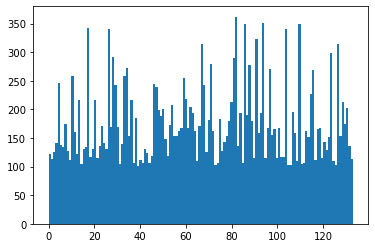

In [97]:

# just gini index and average household income and vacant housing units
reduced_demos = demographics_data[["zip", "SE_A14028_001", "SE_A14011_001", "SE_A18003_001"]]

null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)
#reduced_demos = StandardScaler().fit_transform(reduced_demos)

reduced_demos_no_zip = reduced_demos.drop("zip", axis=1)

clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=3, cluster_selection_method='leaf')
clusterer.fit(reduced_demos_no_zip)

labels = clusterer.labels_
unique_labels = set(labels)
print( " clusters: ", len(unique_labels), " and noise points ", (labels == -1).sum(), ", noise as : ", (labels == -1).sum()/len(labels))

label_sum = []

for k in unique_labels:
    label_sum.append((labels == k).sum())
    
non_noise = labels[labels != -1]

plt.hist(non_noise, bins=len(unique_labels)-1)
plt.show()

In [116]:
clusters = reduced_demos[['zip']]
clusters["cluster"] = labels
clusters = clusters.rename(columns={"zip":"Region"})
clusters.head()

C:\Users\winbase\Anaconda3\envs\mids\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Region,cluster
0,601,-1
1,602,3
2,603,3
3,606,-1
4,610,3


So using just those 3 statistics we can get some pretty reasonable clusters. Now let's join those up with the sales data.

In [93]:
sales_data = pd.read_csv("data/newdata/med_sale_price_yoy.csv", delimiter="	")
sales_data.index = sales_data.index.astype(int)
sales_data = sales_data.dropna(how = 'all', axis = 0)
sales_data = sales_data.fillna(0)
print(sales_data.head())

   Region February 2016 March 2016 April 2016 May 2016 June 2016 July 2016  \
0     501             0          0          0        0         0         0   
1    1005         15.4%       5.7%     -29.7%   -24.0%     33.7%      8.6%   
2    1010             0          0          0        0         0         0   
3    1031        705.0%     612.0%     -24.6%   -24.6%    -83.2%    -13.7%   
4    1037             0          0     -23.9%        0    102.7%    150.4%   

  August 2016 September 2016 October 2016  ... December 2019 January 2020  \
0           0              0            0  ...             0            0   
1        5.7%          -9.1%        -4.1%  ...          7.3%        -4.3%   
2           0              0            0  ...             0            0   
3       -3.3%          -2.0%        27.6%  ...         43.9%       -13.8%   
4      150.4%              0            0  ...             0            0   

  February 2020 March 2020 April 2020 May 2020 June 2020 July 2020  

In [136]:
Jan2020_sales = sales_data[['Region','January 2020']]
Jan2020_sales = Jan2020_sales.merge(clusters, on="Region")
Jan2020_sales["January 2020"] = Jan2020_sales["January 2020"].str.replace(r'%', r'')
Jan2020_sales = Jan2020_sales.fillna(0)
Jan2020_sales.head()

,Region,January 2020,cluster
0,1005,-4.3,28
1,1010,0,29
2,1031,-13.8,-1
3,1057,0,29
4,1068,33.3,33


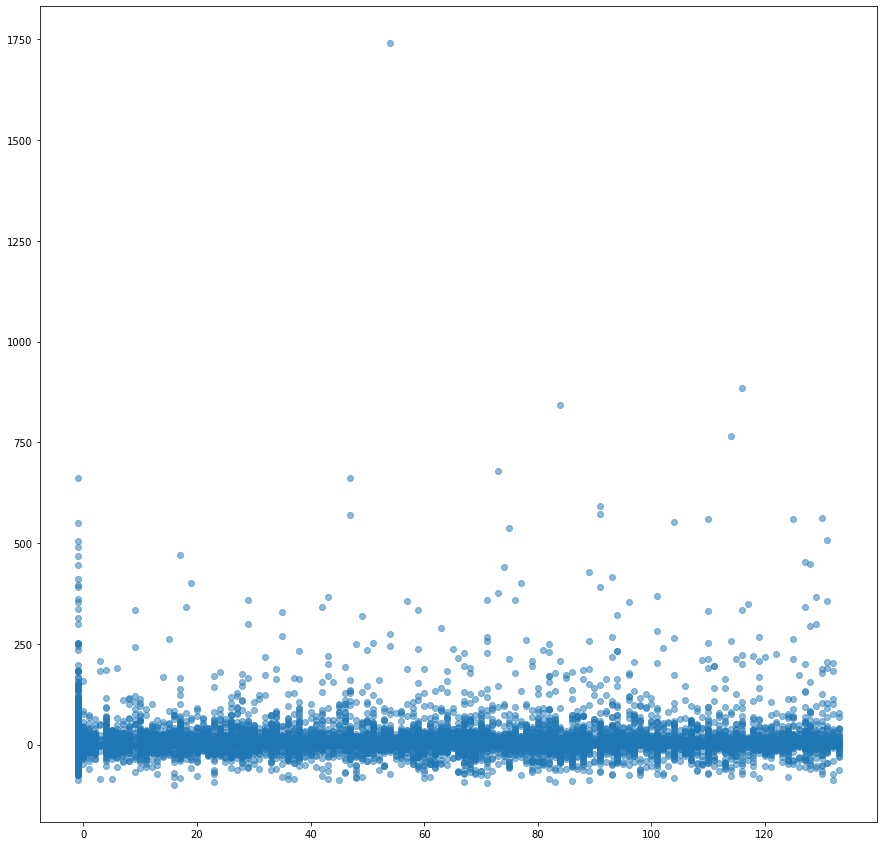

In [147]:
#colors = np.random.rand(N)
fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter( Jan2020_sales["cluster"].astype(int), Jan2020_sales["January 2020"].astype(float), alpha=0.5)

In [ ]:

med_yoy_by_cluster = []

for cluster in np.unique(Jan2020_sales["cluster"]):
    med_yoy_by_cluster.append(Jan2020_sales["January 2020"])

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter( Jan2020_sales["cluster"].astype(int), Jan2020_sales["January 2020"].astype(float), alpha=0.5)